In [1]:
import pandas as pd
import numpy as np
import collections
import copy
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nlp.utils import (
    plot_histogram,
    get_completetext,
    plot_wordcloud,
    print_statistics,
    groups_frequency_sort)
from nlp.text_statistics import (
    count_tokens,
    unique_tokens
)
from utils.read_files import (
    get_items)
from item.item_list import (
    ItemList,
    Item
)
from item.utils import get_tokens_set
import math
sns.set()

# Termos cujos grupos serão caracterizados:
- alcool
- vitamina
- acido
- lorazepam
- luva
- mascara
- algodao
- dipirona
- sabonete
- sabao
- pen
- atenolol
- alopurinol
- dea
- estetoscopio
- maca
- hospitalar
- reanimador
- esfigmomanometro
- oximetro
- camisola

In [2]:
termos = [
    "alcool",
    "vitamina",
    "acido",
    "lorazepam",
    "luva",
    "mascara",
    "algodao",
    "dipirona",
    "sabonete",
    "sabao",
    "pen",
    "atenolol",
    "alopurinol",
    "dea",
    "estetoscopio",
    "maca",
    "hospitalar",
    "reanimador",
    "esfigmomanometro",
    "oximetro",
    "camisola"
]

# Carregar dados de clusters

In [3]:
clusters = pd.read_csv("../dados/output/cluster_prices_statistics_year.csv.zip", sep=';')
items = pd.read_csv("../dados/output/items_clusters_train.csv.zip", sep=';')
items = items[items.outlier != 1] # Desconsiderar outliers

In [4]:
items.head()

,item_id,seq_dim_licitacao,outlier,cluster,dsc_unidade_medida,ano,description,original,areas,price
150,4010,716236,0,achocolatar_24,pacote,2017,achocolatar po 400 gr base acucar cacau maltod...,"Achocolatado em pó de 400gr - ACHOCOLATADO, em...",Vazio,4.33
151,4951,716287,0,achocolatar_24,pacote,2018,achocolatar po 400 gr base acucar cacau maltod...,"Achocolatado em pó de 400gr - ACHOCOLATADO, em...",Vazio,3.88
152,31955,722115,0,achocolatar_24,pacote,2017,achocolatar po ii embalagem 400 g composicao a...,Achocolatado em po II - embalagem 400 g. Compo...,Assistência Social | Educação,2.99
153,158513,749927,0,achocolatar_24,unidade,2015,achocolatar po diet 39 menos caloria 35 cacau ...,ACHOCOLATADO EM PO DIET - Achocolatado em pó d...,Vazio,10.35
154,161886,750062,0,achocolatar_24,unidade,2018,achocolatar po diet 39 menos caloria 35 cacau ...,ACHOCOLATADO EM PO DIET - Achocolatado em pó d...,Vazio,10.90


In [5]:
clusters.head()

,cluster,dsc_unidade_medida,ano,mean,count,max,min,median,std,var,quantile_1,quantile_3
0,a100_0,tb,2017,56.000000,2,56.00,56.00,56.00,0.000000,0.000000,56.00,56.00
1,a100_0,tubo,2015,60.100000,1,60.10,60.10,60.10,NaN,NaN,60.10,60.10
2,a100_0,tubo,2017,32.200000,1,32.20,32.20,32.20,NaN,NaN,32.20,32.20
3,a100_0,tubos,2017,50.550000,1,50.55,50.55,50.55,NaN,NaN,50.55,50.55
4,a100_0,unidade,2015,52.704615,13,73.60,32.84,60.10,15.247907,232.498677,34.04,60.10


## Volume por Ano

### Quantidade de grupos por ano

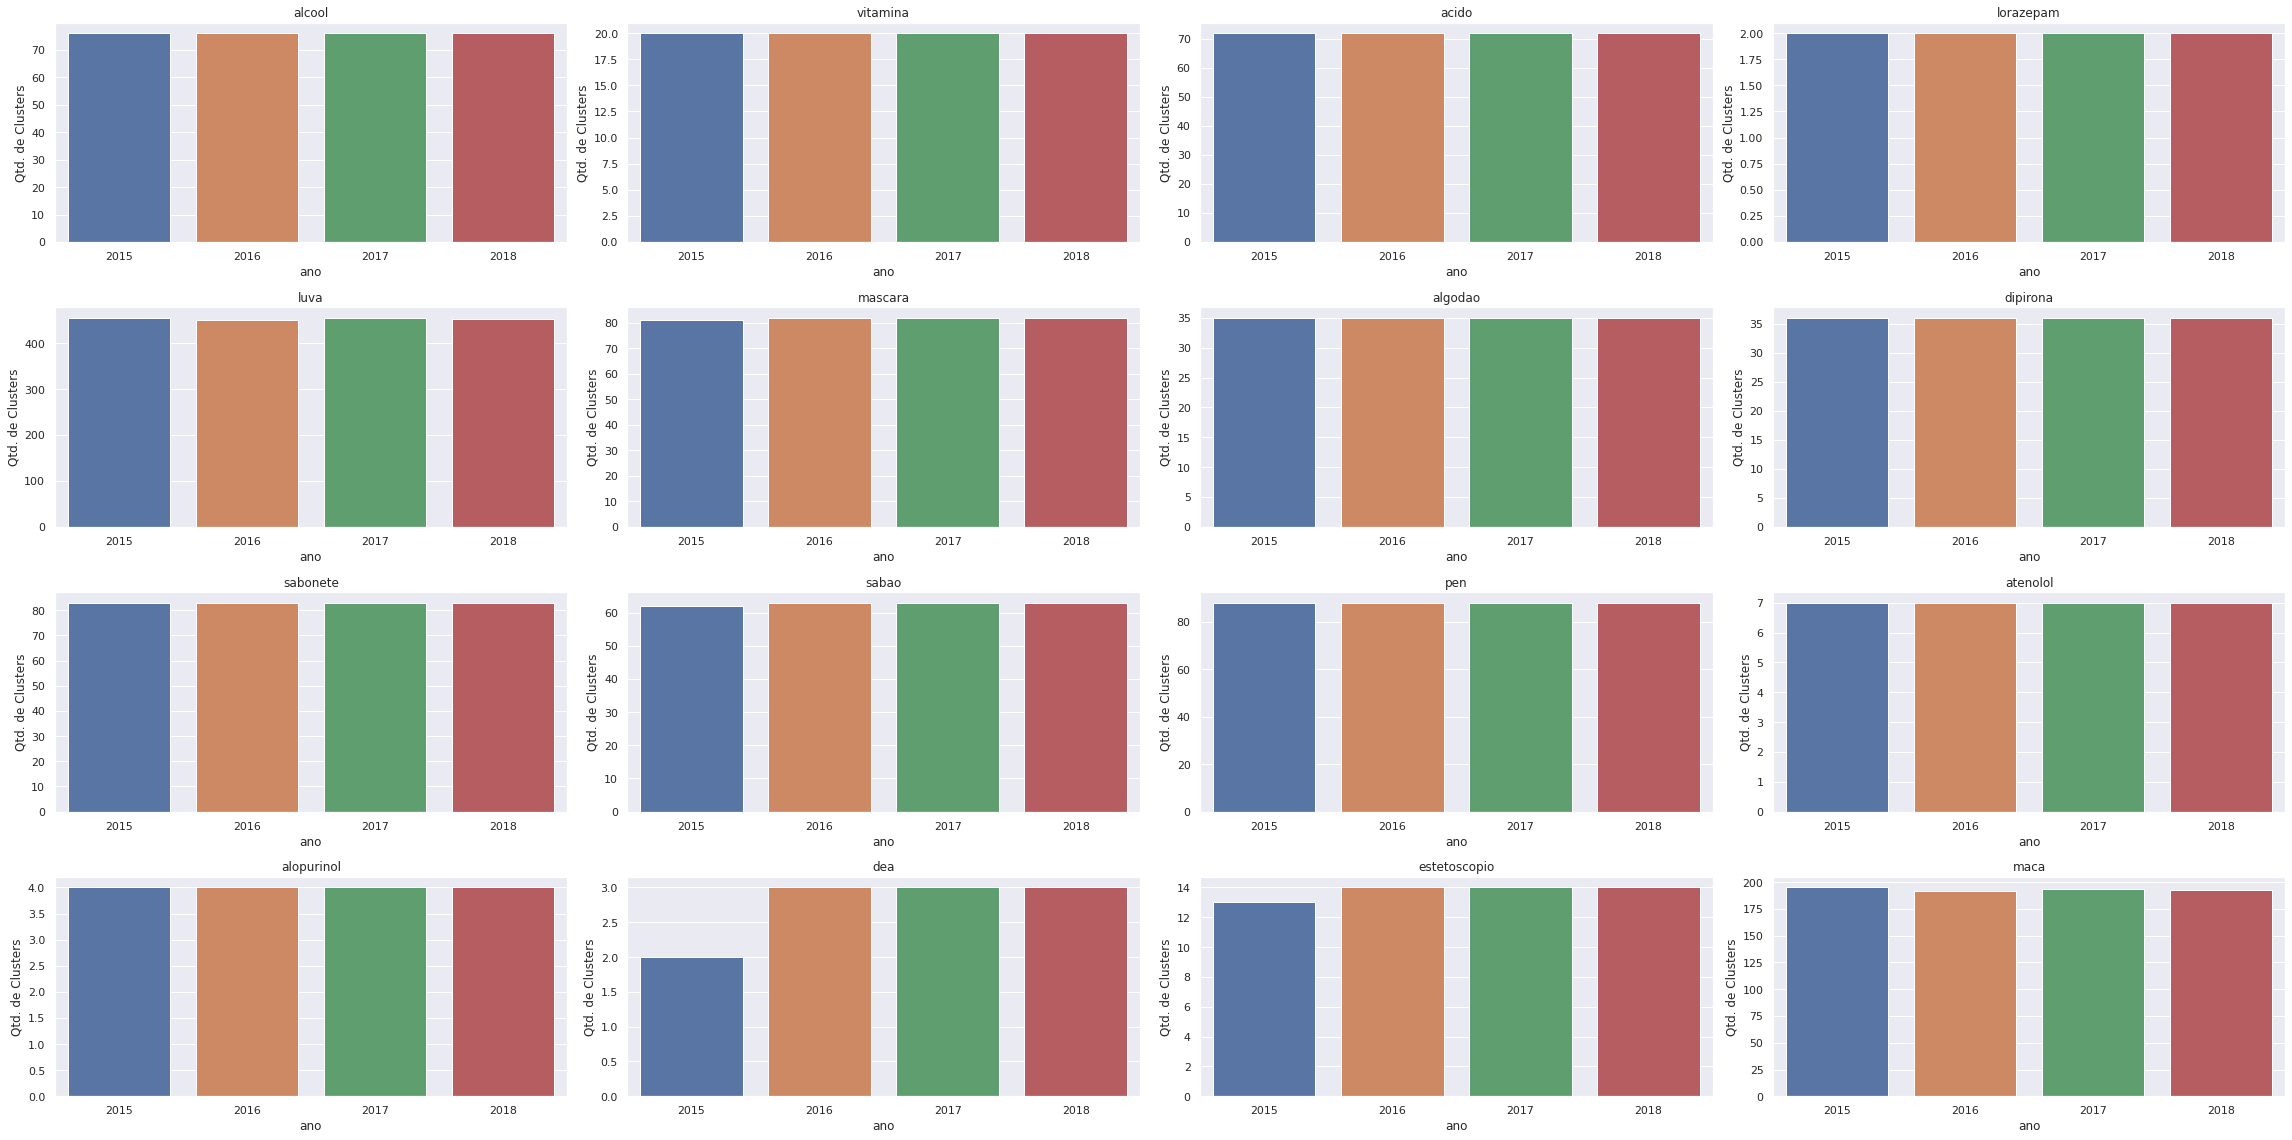

In [11]:
fig, axs = plt.subplots(math.floor(math.sqrt(len(termos))), math.floor(math.sqrt(len(termos))), figsize=(32,16))
for ax, termo in zip(axs.flat, termos):
    items_termo = items[items.cluster.str.startswith(termo)]
    ax.set(xlabel="Ano", ylabel="Qtd. de Clusters", title=termo)
    if items_termo.empty:        
        continue
    qtd_clusters = items_termo.groupby("ano").cluster.unique().apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax)
fig.tight_layout()
plt.show()    

## Quantidade de itens nos grupos

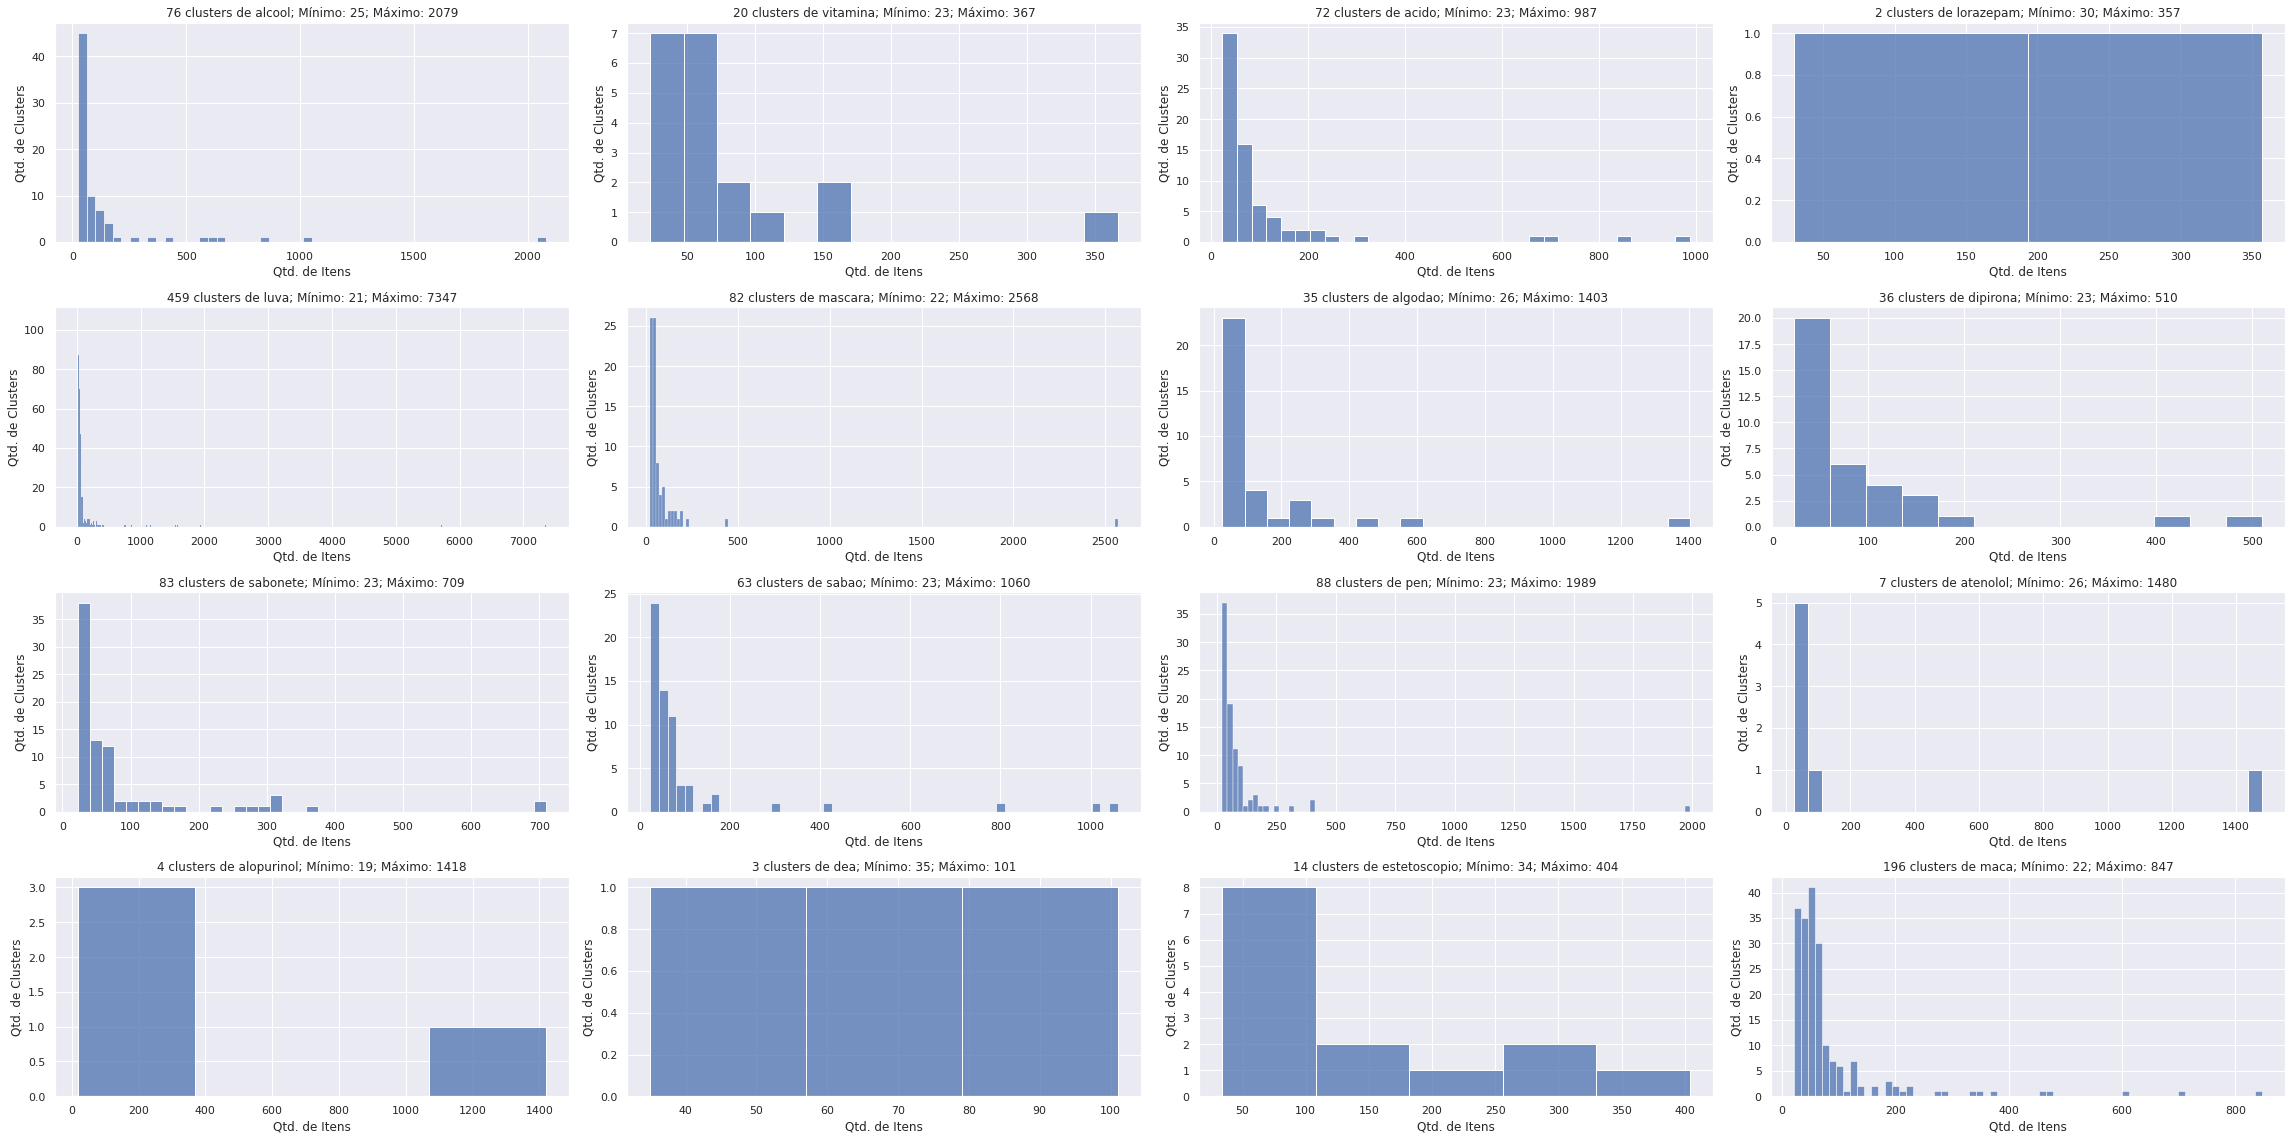

In [15]:
fig, axs = plt.subplots(math.floor(math.sqrt(len(termos))), math.floor(math.sqrt(len(termos))), figsize=(32,16))
for ax, termo in zip(axs.flat, termos):
    items_termo = items[items.cluster.str.startswith(termo)]
    qtd_itens = items_termo.groupby("cluster").size()
    sns.histplot(x=qtd_itens, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {}; Máximo: {}".format(len(qtd_itens),termo, min(qtd_itens), max(qtd_itens)))
fig.tight_layout()
plt.show()    

## Variações de preço dos grupos

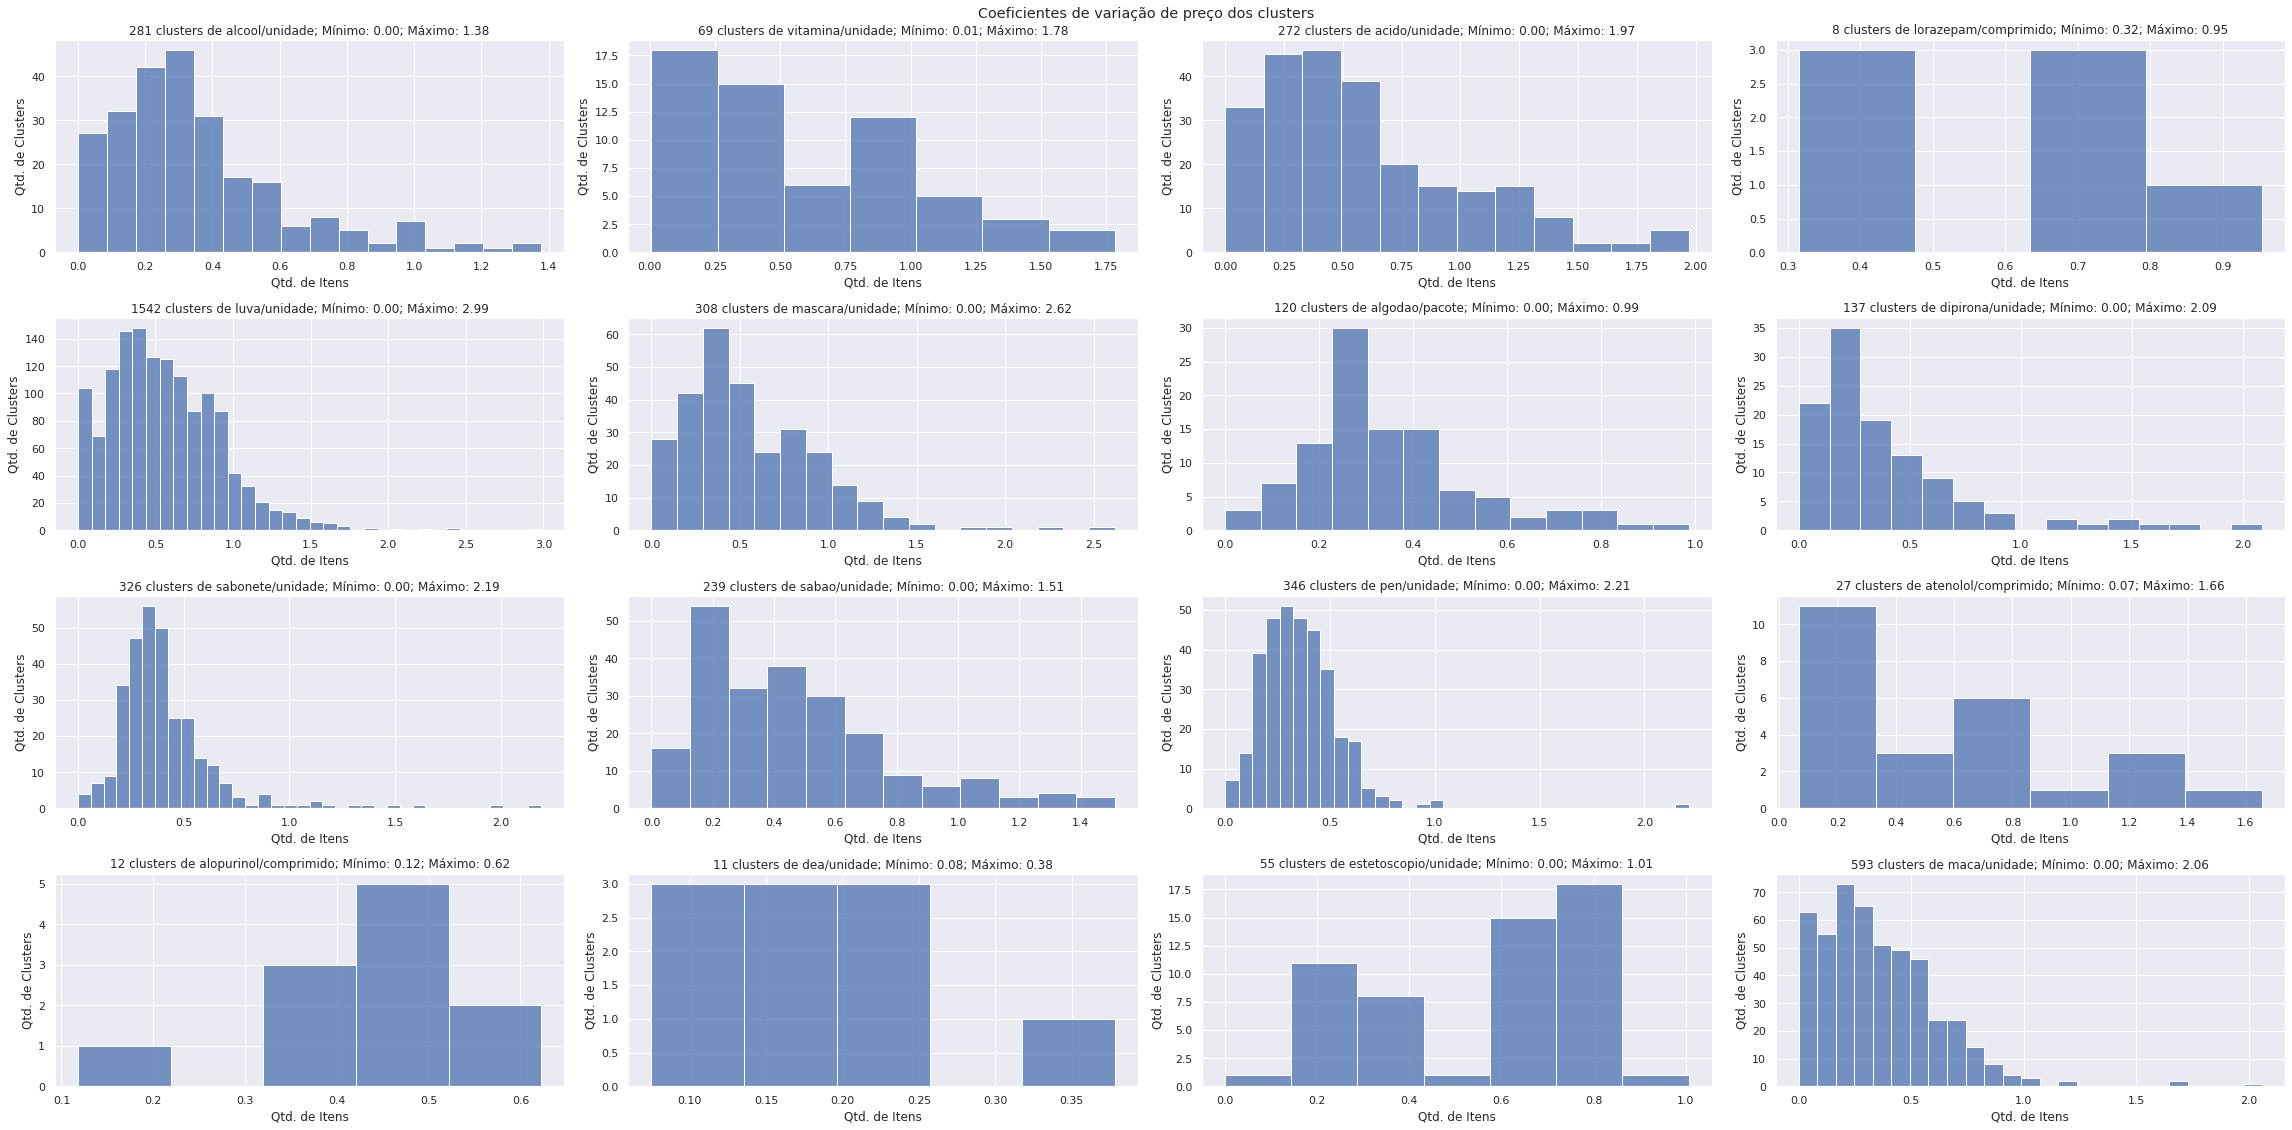

In [18]:
fig, axs = plt.subplots(math.floor(math.sqrt(len(termos))), math.floor(math.sqrt(len(termos))), figsize=(32,16))
for ax, termo in zip(axs.flat, termos):
    clusters_termo = clusters[(clusters.cluster.str.startswith(termo))]
    unidade = clusters_termo.groupby("dsc_unidade_medida")["count"].sum().idxmax() if unidade != 'litro' else 'unidade'
    clusters_termo = clusters_termo[clusters_termo.dsc_unidade_medida == unidade]
    cv = clusters_termo["std"] / clusters_termo["mean"]
    sns.histplot(x=cv, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}/{}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, unidade, min(cv), max(cv)))
fig.suptitle("Coeficientes de variação de preço dos clusters")
fig.tight_layout()
plt.show()

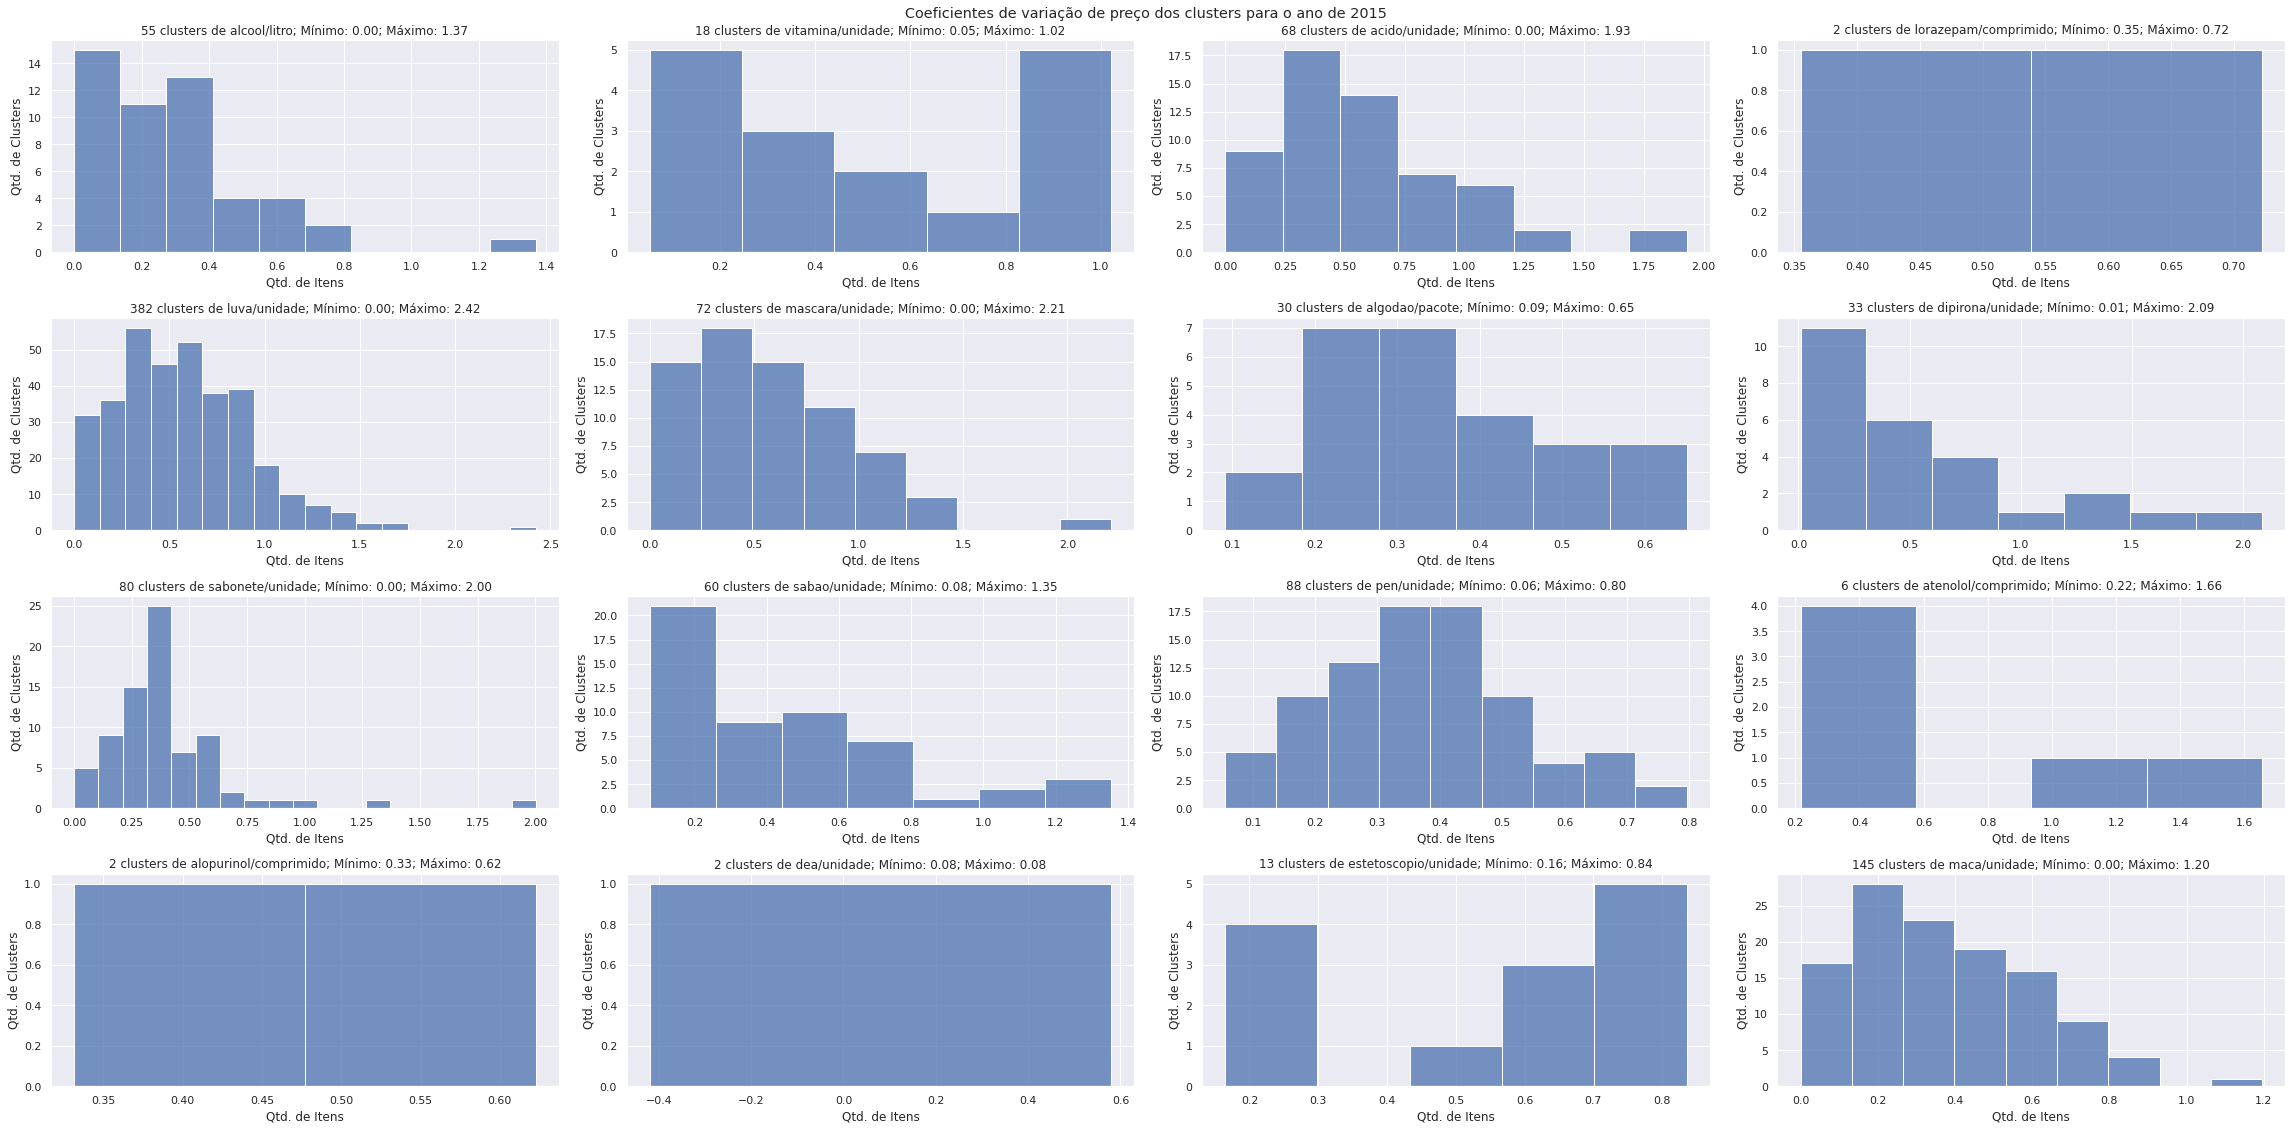

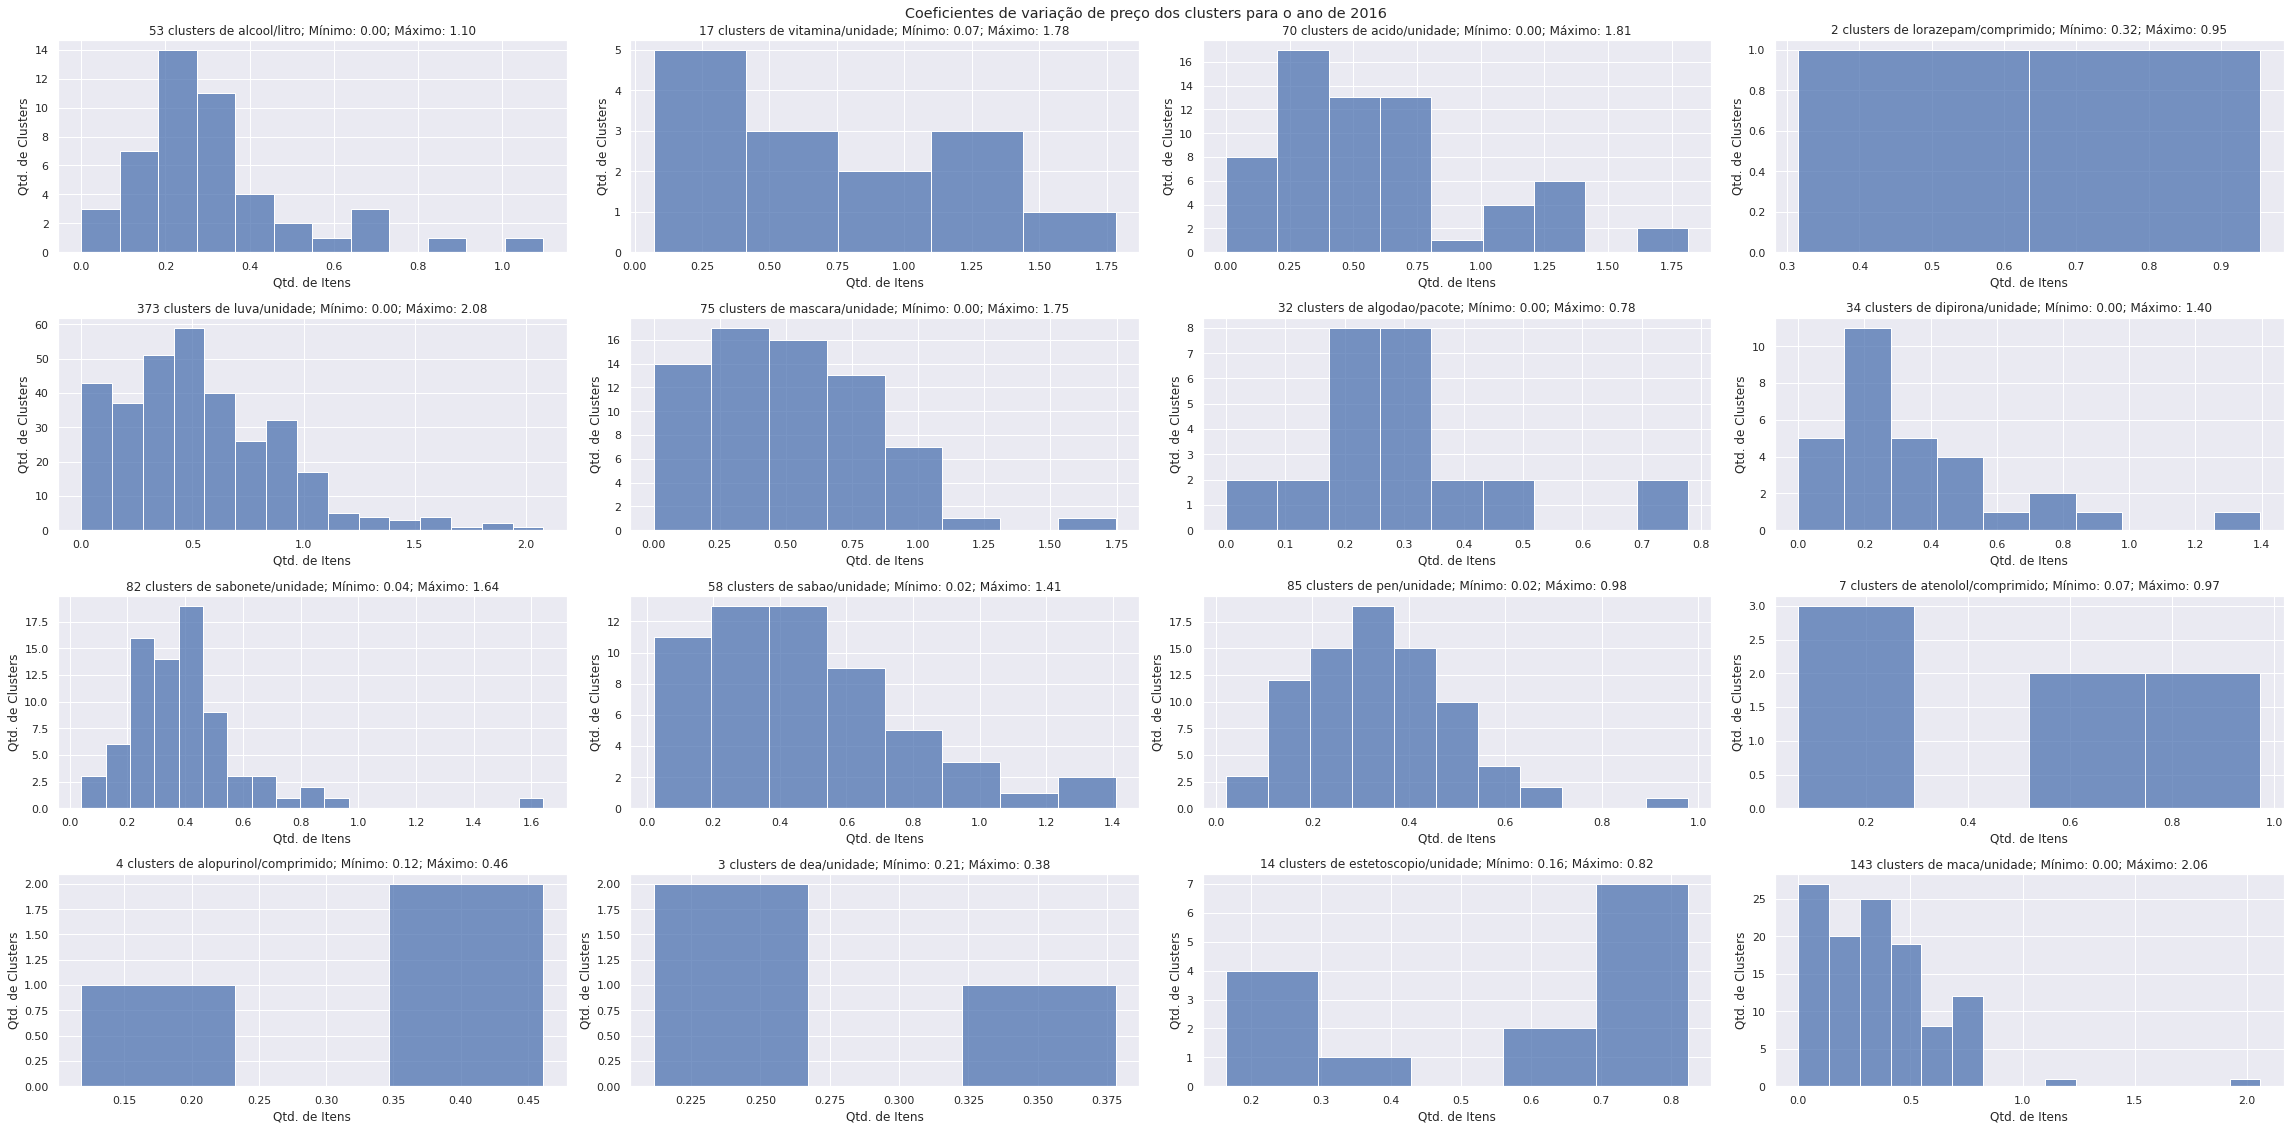

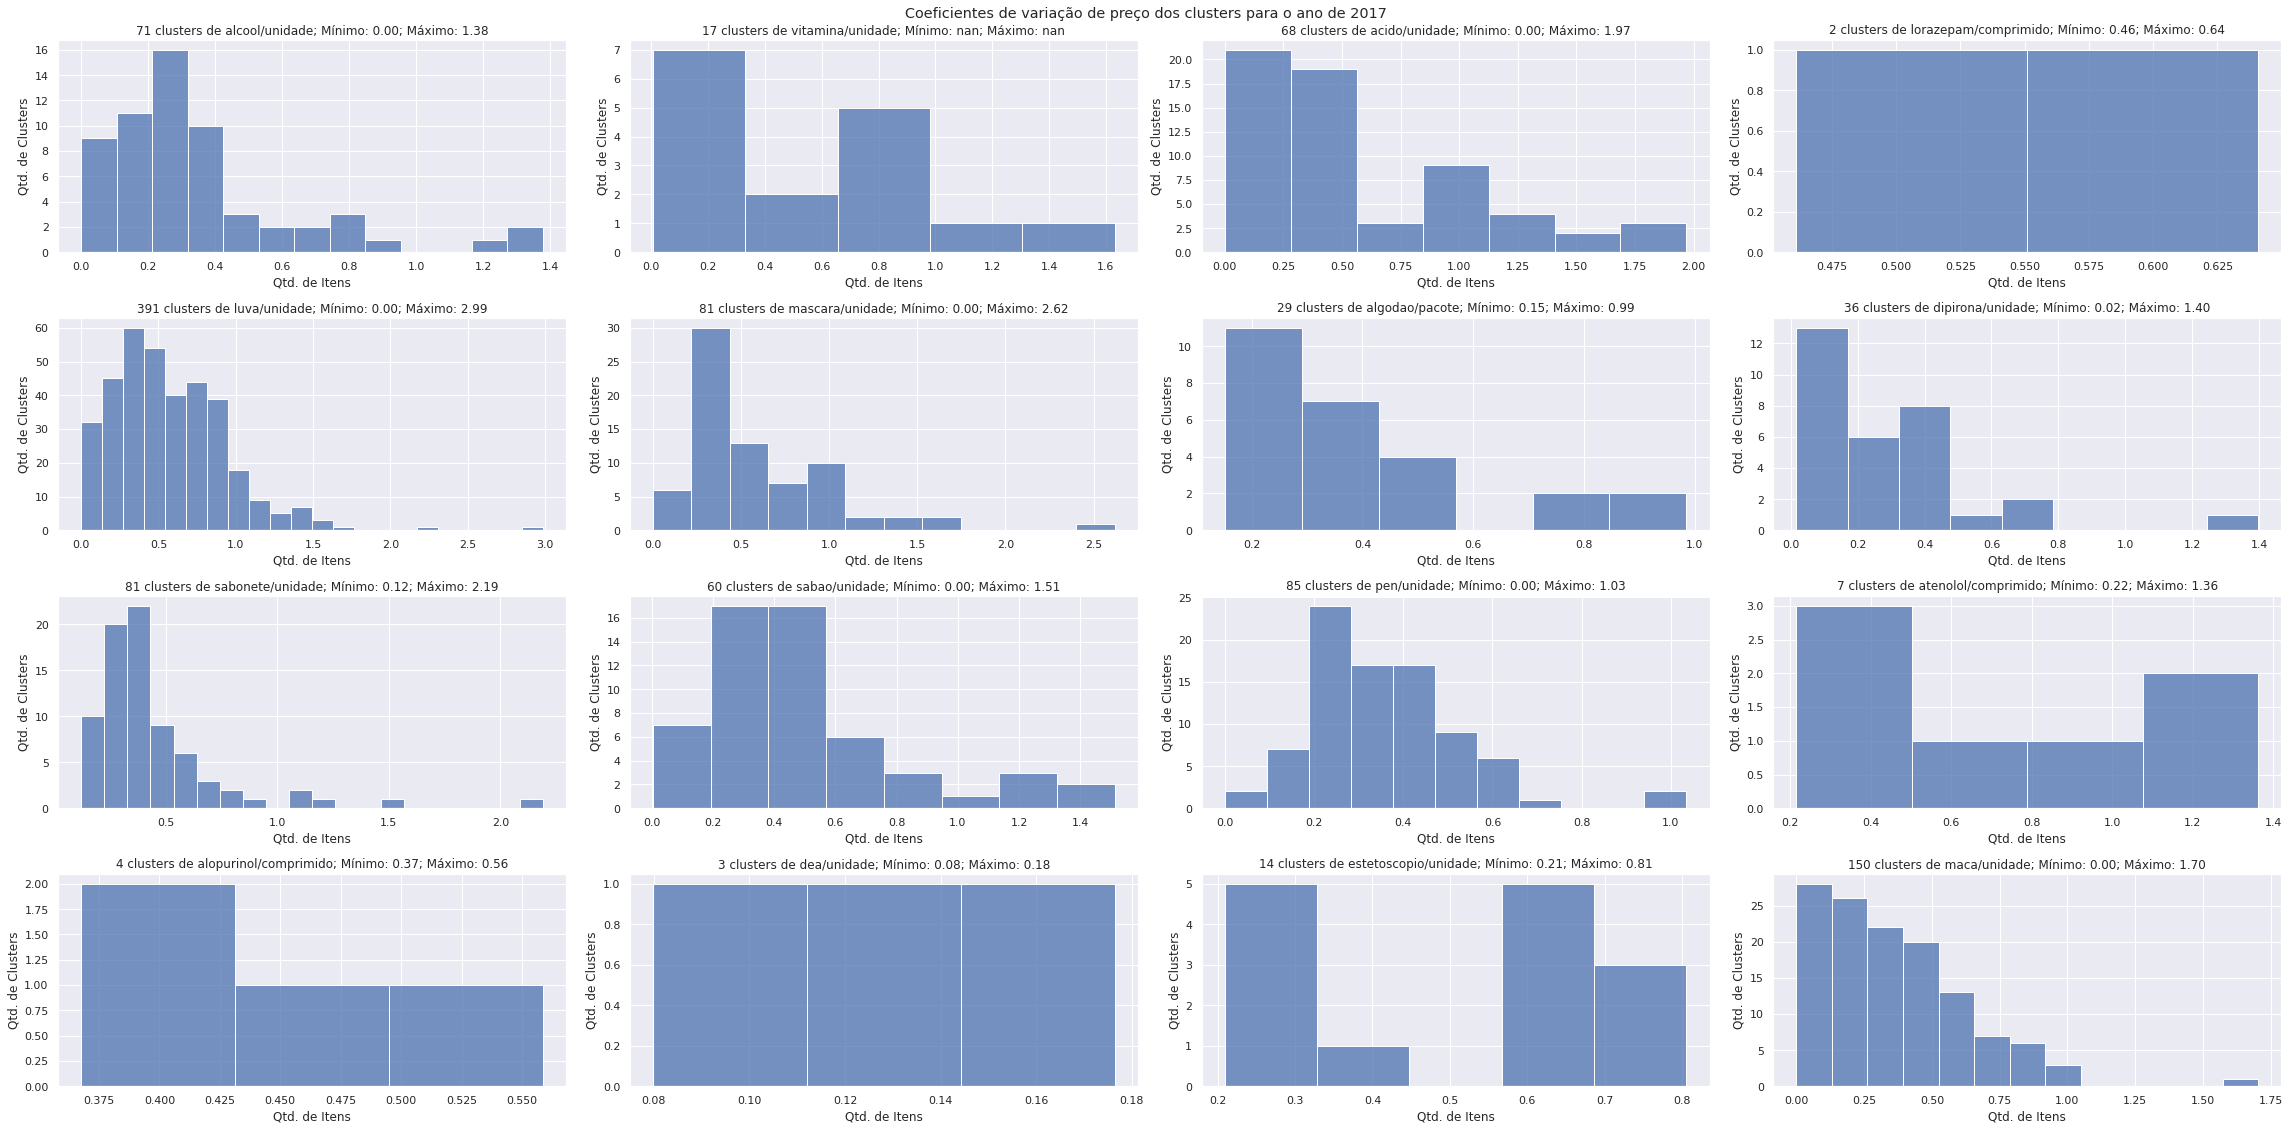

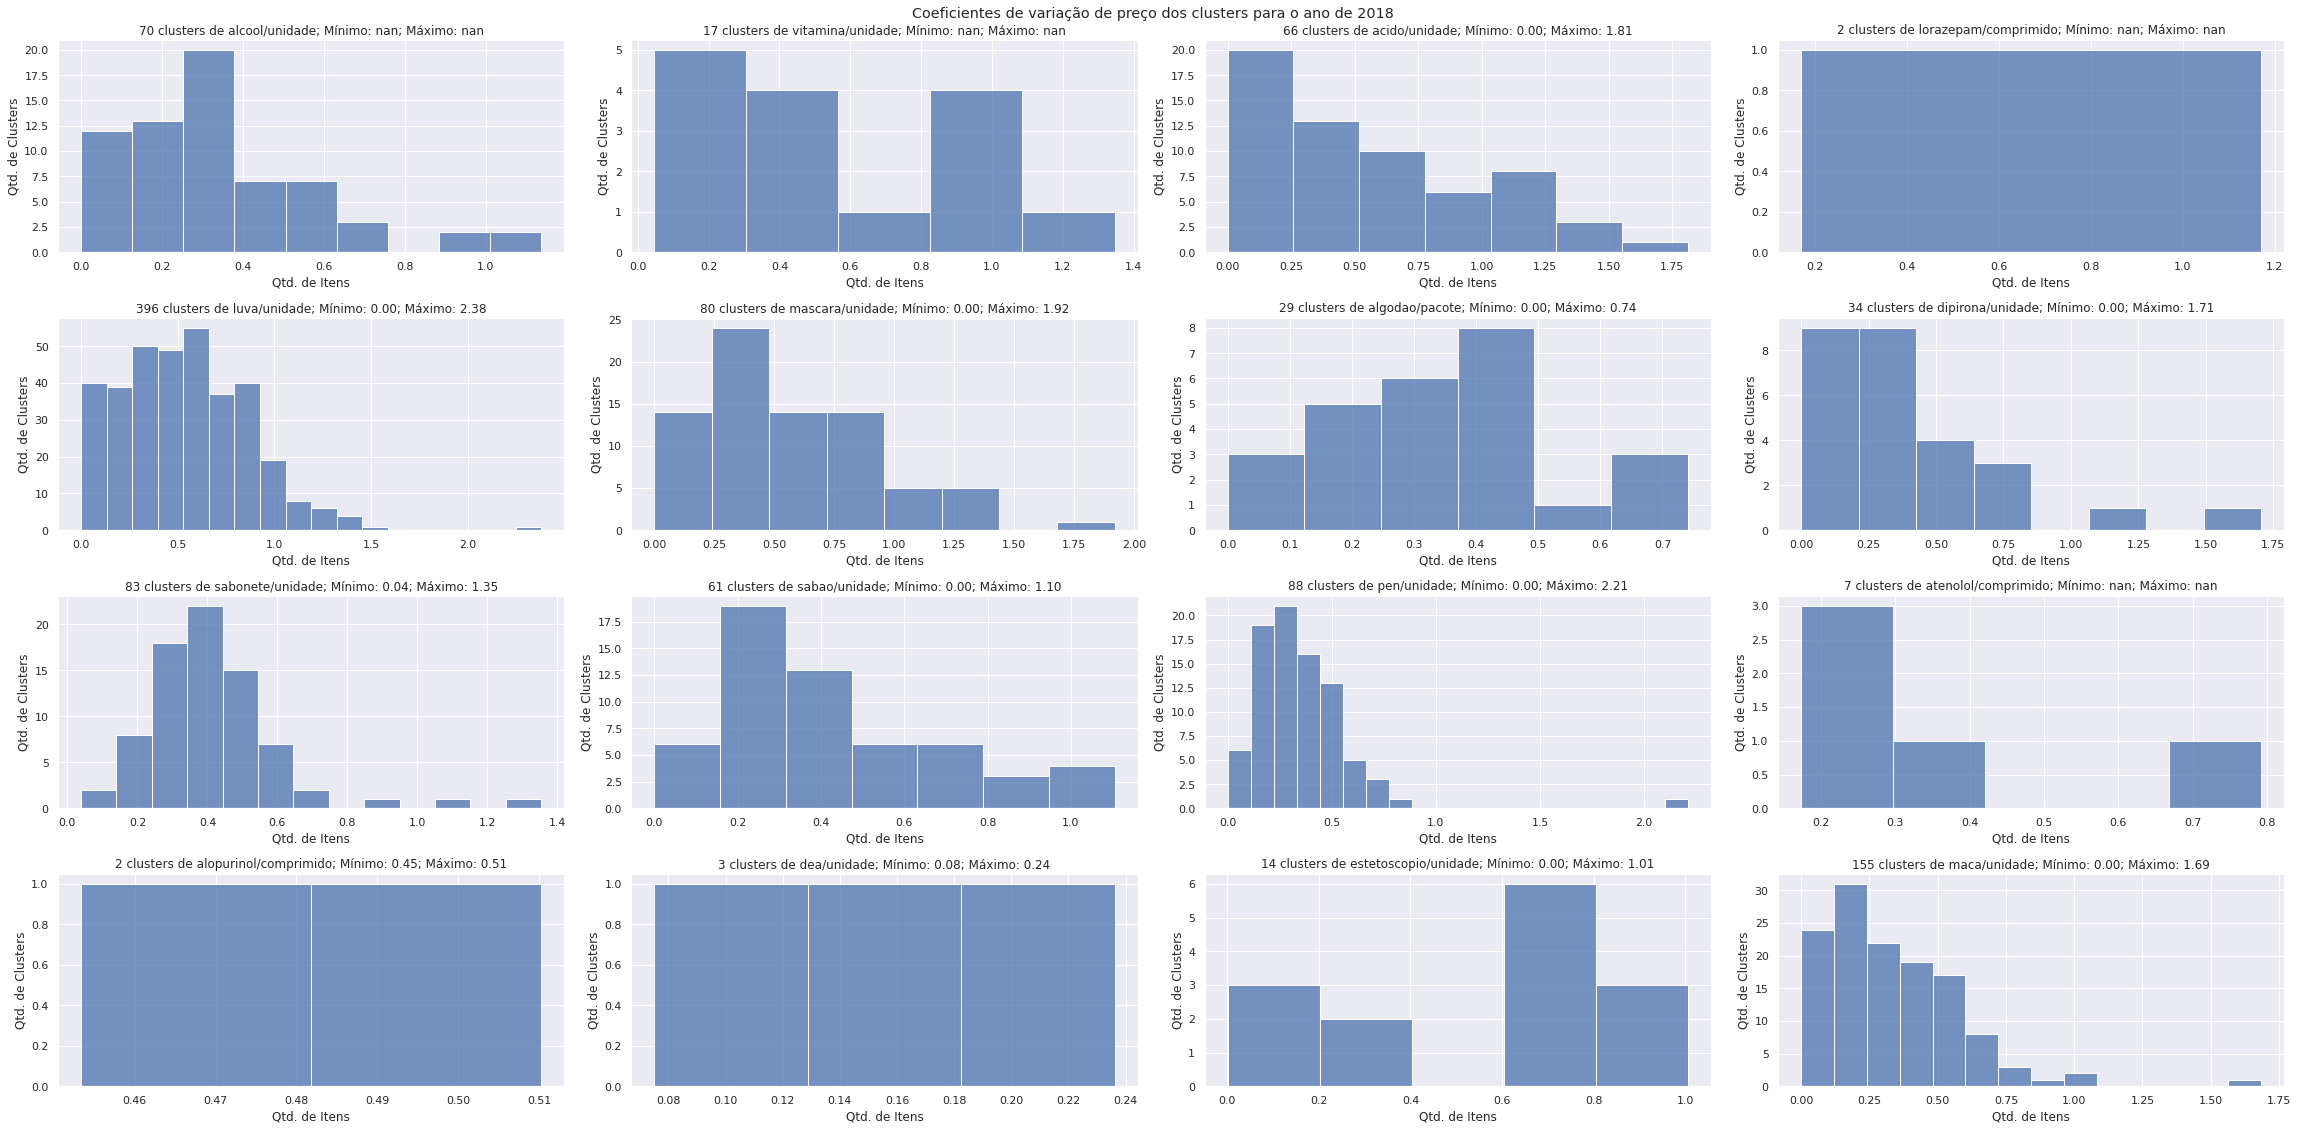

In [19]:
for ano in np.sort(clusters.ano.unique()):
    fig, axs = plt.subplots(math.floor(math.sqrt(len(termos))), math.floor(math.sqrt(len(termos))), figsize=(32,16))
    for ax, termo in zip(axs.flat, termos):
        clusters_termo = clusters[(clusters.cluster.str.startswith(termo)) & (clusters.ano == ano)]
        unidade = clusters_termo.groupby("dsc_unidade_medida")["count"].sum().idxmax() if unidade != 'litro' else 'unidade'
        clusters_termo = clusters_termo[clusters_termo.dsc_unidade_medida == unidade]
        cv = clusters_termo["std"] / clusters_termo["mean"]
        sns.histplot(x=cv, ax=ax)
        ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}/{}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, unidade, min(cv), max(cv)))
    fig.suptitle("Coeficientes de variação de preço dos clusters para o ano de {}".format(ano))
    fig.tight_layout()
    plt.show()